How does our TFR (with the 0pt calibrated with the EDD, and fit to the ITFR) compare with that of Cosmicflows-4?

In [1]:
import numpy as np

from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u

import pickle

from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [2]:
c = 3e5

q0 = 0.2

V0 = 2.5

# Data

## fuji

In [5]:
tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
# tfuji = Table.read('/Users/kdouglass/Documents/Research/data/DESI/SV/desi_pv_tf_fuji_healpix.fits')
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195


## SGA

In [8]:
SGA = Table.read('../../data/SGA-2020_ALFALFA.fits')
# SGA = Table.read('/Users/kdouglass/Documents/Research/data/SGA/SGA-2020_ALFALFA.fits')

SGA['ALFALFA_index'].name = 'ALFALFA_AGCNr'

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,ALFALFA_AGCNr
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int64
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0,-1
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.544437500000

In [9]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

## Separate fuji data into center and off-center observations

In [10]:
tfuji['SKY_FIBER_DIST'] = 0.
tfuji['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in np.unique(tfuji['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tfuji['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tfuji['RA'][obs_idx], 
                             dec=tfuji['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tfuji['SKY_FIBER_DIST'][obs_idx] = sep2d
    tfuji['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

In [11]:
centers_boolean = tfuji['SKY_FIBER_DIST_R26'] < 0.1

fuji_centers = tfuji[centers_boolean]
fuji_axis = tfuji[~centers_boolean]

### Clean the fuji center observations

Only keep those with
 * `DELTACHI2` > 25
 * `ZWARN` == 0

In [12]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

## ALFALFA

Read in our version of the SGA that includes the index value of the galaxy in the ALFALFA data file.  (This file was made with the `ALFALFA_radec_match.py` script, currently living in my (Kelly's) data folder on my local machine.)

In [13]:
ALFALFA = Table.read('../../data/a100.code12.table2.190808.txt', 
# ALFALFA = Table.read('/Users/kdouglass/Documents/Research/data/ALFALFA/a100.code12.table2.190808.txt',
                     format='ascii.csv', 
                     include_names=['AGCNr', 'W50', 'sigW'])

ALFALFA[:5]

AGCNr,W50,sigW
int64,int64,int64
105367,274,39
333313,313,20
331060,160,4
331061,260,45
104570,245,6


In [14]:
ALFALFA_dict = {}

for i in range(len(ALFALFA)):
    
    ALFALFA_dict[ALFALFA['AGCNr'][i]] = i

## If an SGA galaxy has at least one observation at its center, set the redshift and HI velocity of that galaxy

In [15]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

SGA['V_HI'] = np.nan
SGA['VERR_HI'] = np.nan

weights = 1./(good_centers['ZERR']**2)

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the average redshift of all good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))
    
    # Set the HI velocity width of this galaxy
    if SGA['ALFALFA_AGCNr'][SGA_idx] >= 0:
        
        ALFALFA_idx = ALFALFA_dict[SGA['ALFALFA_AGCNr'][SGA_idx]]
        
        SGA['V_HI'][SGA_idx] = ALFALFA['W50'][ALFALFA_idx] - 6. # Adjustment from Kourkchi et al. (2020a), Sec. 2.2
        SGA['VERR_HI'][SGA_idx] = ALFALFA['sigW'][ALFALFA_idx]

### Filter SGA to keep only those objects with center observations and HI velocities

In [16]:
HI = np.isfinite(SGA['V_HI'])
centers = np.isfinite(SGA['Z_DESI'])

################################################################################
# Keep all observations of each galaxy that have HI velocities
#-------------------------------------------------------------------------------
SGA_ID_dist = SGA['SGA_ID'][HI & centers]

centers_dist = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_dist)]

axis_dist = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_dist)]
################################################################################

print('fuji galaxies with HI velocities and good center observations:', len(np.unique(centers_dist['SGA_ID'])))
print('fuji off-center observations in galaxies with HI velocities:', len(axis_dist))

fuji galaxies with HI velocities and good center observations: 314
fuji off-center observations in galaxies with HI velocities: 1083


# Calculate the rotational velocities

In [17]:
axis_dist['SKY_FIBER_DIST'] = 0.
axis_dist['SKY_FIBER_DIST_R26'] = 0.
axis_dist['V_ROT'] = np.nan
axis_dist['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_dist['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis_dist['RA'][obs_idx], 
                             dec=axis_dist['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis_dist['SKY_FIBER_DIST'][obs_idx] = sep2d
    axis_dist['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_dist['V_ROT'][obs_idx] = c*(axis_dist['Z'][obs_idx] - z_center)
    axis_dist['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_dist['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------


    #---------------------------------------------------------------------------
    # Correct rotational velocities for offset from main axis
    #---------------------------------------------------------------------------
    # Compute the position angle from the center to the observation
    pa = center_coords.position_angle(target_coords).to(u.deg)

    # Compute the difference between these position angles and that of the 
    # major axis
    delta_pa = np.abs(pa - SGA['PA'][sga_idx]*u.deg)

    # Correct the velocities for these differences
    axis_dist['V_ROT'][obs_idx] /= np.cos(delta_pa.to(u.radian))
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_dist['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

# Cut for galaxies with HI velocities suitable for calibrating the TFR

Requirements:
 * $10 < V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $\Delta V / V_{min} \leq 5$
 * $i > 45^\circ$
 * Spiral-type morphology
 * Passes visual inspection

## Velocity cut

In [18]:
r0p3 = (axis_dist['SKY_FIBER_DIST_R26'] > 0.3) & (axis_dist['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = (np.abs(axis_dist['V_ROT']) < 1000) & (np.abs(axis_dist['V_ROT']) > 10)

good_axis_dist = axis_dist[r0p3 & Vgood]

print(len(good_axis_dist), len(np.unique(good_axis_dist['SGA_ID'])))

301 149


## Relative velocity cut

In [19]:
good_deltaV = np.ones(len(good_axis_dist), dtype=bool)

for sga_id in np.unique(good_axis_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_dist['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis_dist['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis_dist['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis_dist['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis_dist['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis_dist['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_dist['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis_dist['DELTACHI2'] >= 25
            
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, 
            # they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis_dist['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_dist['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_dist['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False

In [20]:
good_deltaV_axis_dist = good_axis_dist[good_deltaV]

print(len(good_deltaV_axis_dist), len(np.unique(good_deltaV_axis_dist['SGA_ID'])))

301 149


## Inclination angle cut

In [21]:
SGA['cosi2'] = (SGA['BA']**2 - q0**2)/(1 - q0**2)
SGA['cosi2'][SGA['cosi2'] < 0] = 0

good_deltaV_axis_dist['iSGA'] = -1

for i in range(len(good_deltaV_axis_dist)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_deltaV_axis_dist['SGA_ID'][i]]
    
    good_deltaV_axis_dist['iSGA'][i] = sga_idx
    
good_deltaV_axis_dist['cosi2'] = SGA['cosi2'][good_deltaV_axis_dist['iSGA']]

In [22]:
i_min = 45. # degrees

cosi2_max = np.cos(i_min*np.pi/180.)**2

edge = good_deltaV_axis_dist['cosi2'] <= cosi2_max

good_edge_axis_dist = good_deltaV_axis_dist[edge]

print(len(good_edge_axis_dist), len(np.unique(good_edge_axis_dist['SGA_ID'])))

251 125


## Morphology cut

In [23]:
good_edge_axis_dist['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_dist['iSGA']]

# np.unique(good_edge_axis_dist['MORPHTYPE'])

In [24]:
spirals = np.zeros(len(good_edge_axis_dist), dtype=bool)

for i in range(len(good_edge_axis_dist)):
    
    try:    
        if (good_edge_axis_dist['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_dist['MORPHTYPE'][i][:2] != 'S0'):
            spirals[i] = True
    except IndexError:
        print(good_edge_axis_dist['MORPHTYPE'][i])

good_edge_spirals_axis_dist = good_edge_axis_dist[spirals]

print(len(good_edge_spirals_axis_dist), len(np.unique(good_edge_spirals_axis_dist['SGA_ID'])))

--
--
--
--
--
--
--
--
--
223 106


In [25]:
SGA_idx = []

for SGA_id in np.unique(good_edge_spirals_axis_dist['SGA_ID']):
    
    SGA_idx.append(SGA_dict[SGA_id])

SGA[SGA_idx]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,ALFALFA_AGCNr,Z_DESI,ZERR_DESI,V_HI,VERR_HI,cosi2
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int64,float64,float64,float64,float64,float32
21905,SGA-2020 21905,PGC2057303,2057303,219.091098,34.9634106,Sc,12.24,0.46881336,0.374973,0.030079473,23.690481,16.707,False,LEDA-20181114,5858,PGC2057303,1,True,219.091098,34.9634106,0.46881336,2191p350,219.09108657904613,34.9633173924782,0.7438286,SB26,9.770802,0.38141513,219.09112462525545,34.96344218485945,16.3721,7.3809056,6.9394255,6.438956,6.945866,9.164333,11.25903,13.091548,14.669391,16.164392,18.16269,19.857664,22.314857,17.193132,16.8005,16.566973,16.881731,16.509058,16.29431,16.72109,16.351477,16.144707,16.604822,16.236557,16.045586,16.522583,16.177313,15.99385,16.47039,16.127832,15.946779,16.435534,16.100458,15.924124,16.417917,16.084673,15.914168,16.399458,16.068775,15.904226,0.12528424,0.1263019,0.15110311,0.12396254,0.17606099,0.17370777,0.21082695,0.13444765,0.27963006,0.041218147,0.04442056,0.047901593,0.036485113,0.038643964,0.04148492,0.033336964,0.0351727,0.03789257,0.03112216,0.03276487,0.03544987,0.029583538,0.031440873,0.034148198,0.028558232,0.030356243,0.033018697,0.027808832,0.02968668,0.032411925,0.027409067,0.029297458,0.03215074,0.026979305,0.028897557,0.03188434,16.368975,0.22579144,6.275678,4.8076715,0.6099423,16.044615,0.22601731,4.7760386,4.7340226,0.24342757,15.884407,0.20401548,4.4418197,4.934887,0.20438476,0,729387,0.0300903938271713,2.6173743106653998e-06,142.0,34.0,0.1098724
25532,SGA-2020 25532,SDSSJ130354.42+281837.9,4107586,195.9767

## Visual inspection cut

This removes any observations that are contaminated by foreground stars or other galaxies.

**Note:** VI was done in the `fuji_zero-point_ALFALFA_KAD.ipynb` notebook.

In [27]:
VI_remove = Table.read('fuji_ALFALFA_VI.txt', format='ascii.commented_header')

remove_targets = np.zeros(len(good_edge_spirals_axis_dist), dtype=bool)

for targetid in VI_remove['TARGETID']:
    
    remove_targets = remove_targets & (good_edge_spirals_axis_dist['TARGETID'] == targetid)
    
VI_good_edge_spirals_axis_dist = good_edge_spirals_axis_dist[~remove_targets]

print(len(VI_good_edge_spirals_axis_dist), len(np.unique(VI_good_edge_spirals_axis_dist['SGA_ID'])))

# VI_good_edge_spirals_axis_dist = good_edge_spirals_axis_dist

223 106


# Comparison of the two TFRs

## Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$:

\begin{equation}
  \bar{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

In [28]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_err'] = np.nan

VI_good_edge_spirals_axis_dist['R_MAG_SB26'] = np.nan
VI_good_edge_spirals_axis_dist['R_MAG_SB26_ERR'] = np.nan

weights = 1./(VI_good_edge_spirals_axis_dist['V_ROT_ERR']**2)

for sga_id in np.unique(VI_good_edge_spirals_axis_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = VI_good_edge_spirals_axis_dist['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(VI_good_edge_spirals_axis_dist['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    SGA['V_0p33R26_err'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))

In [29]:
# Make a catalog of just those galaxies with velocities
SGA_0pt = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

## Compute the absolute magnitudes based on the Cosmicflows-4 TFR

### First, we need to correct the HI velocities for the inclination angle.

In [30]:
SGA_0pt['V_HI_corr'] = SGA_0pt['V_HI']/np.sin(np.arccos(np.sqrt(SGA_0pt['cosi2'])))
SGA_0pt['VERR_HI_corr'] = SGA_0pt['VERR_HI']/np.sin(np.arccos(np.sqrt(SGA_0pt['cosi2'])))

### Now, we use the Tully-Fisher relation calibrated by Cosmicflows-4 (Kourkchi+ 2020) to calculate the absolute magnitudes of these galaxies

Cosmicflows-4 TF calibration:
\begin{equation}
  \overline{M_\lambda} = \text{Slope} \left( \log W^i_{mx} - 2.5 \right) + \overline{\text{ZP}}
\end{equation}
where
\begin{equation}
  \overline{\text{ZP}} = \text{ZP} + C_{zp}
\end{equation}
is a correction to the zero-point to account for slightly different distance moduli found with different passbands for the same clusters.

For the $r$-band, the parameter values are
 * slope $= -7.96\pm 0.13$
 * ZP $= -20.57\pm 0.10$
 * $C_{zp} = -0.08\pm 0.13$

In [31]:
CF4_slope = -7.96
CF4_slope_err = 0.13

CF4_ZP = -20.57
CF4_ZP_err = 0.10

CF4_Czp = -0.08
CF4_Czp_err = 0.13

SGA_0pt['R_ABSMAG_SB26_CF4'] = CF4_slope*(np.log10(SGA_0pt['V_HI_corr'] - 6) - 2.5) + CF4_ZP + CF4_Czp
#SGA_0pt['R_ABSMAG_SB26_CF4_err'] = np.sqrt((np.log10(SGA_0pt['V_HI_corr'] - 6) - 2.5)**2 * CF4_slope_err**2 + (CF4_slope/((SGA_0pt['V_HI_corr'] - 6)*np.log(10)))**2 * SGA_0pt['VERR_HI_corr']**2 + CF4_ZP_err**2 + CF4_Czp_err**2)

In [32]:
N_samples = 100000

rng = np.random.default_rng()

m_random = rng.normal(CF4_slope, CF4_slope_err, size=N_samples)
b_random = rng.normal(CF4_ZP, CF4_ZP_err, size=N_samples)
bp_random = rng.normal(CF4_Czp, CF4_Czp_err, size=N_samples)

SGA_0pt['R_ABSMAG_SB26_CF4_err'] = np.nan
SGA_0pt['R_ABSMAG_SB26_CF4_err_stat'] = np.nan

for i in range(len(SGA_0pt)):
    
    v_random = rng.normal(SGA_0pt['V_HI_corr'][i], 
                          SGA_0pt['VERR_HI_corr'][i], 
                          size=N_samples)
    
    ############################################################################
    # Statistical uncertainty
    #---------------------------------------------------------------------------
    Ms_stat = CF4_slope*(np.log10(v_random - 6) - 2.5) + CF4_ZP + CF4_Czp
    
    SGA_0pt['R_ABSMAG_SB26_CF4_err_stat'][i] = np.nanstd(Ms_stat)
    ############################################################################
    
    
    ############################################################################
    # Total uncertainty
    #---------------------------------------------------------------------------
    Ms = m_random*(np.log10(v_random - 6) - 2.5) + b_random + bp_random
    
    SGA_0pt['R_ABSMAG_SB26_CF4_err'][i] = np.nanstd(Ms)
    ############################################################################
    
    
################################################################################
# Systematic uncertainty
#-------------------------------------------------------------------------------
SGA_0pt['R_ABSMAG_SB26_CF4_err_sys'] = np.sqrt(SGA_0pt['R_ABSMAG_SB26_CF4_err']**2 - SGA_0pt['R_ABSMAG_SB26_CF4_err_stat']**2)
################################################################################

/tmp/ipykernel_966813/4247954469.py:21: RuntimeWarning: invalid value encountered in log10
  Ms_stat = CF4_slope*(np.log10(v_random - 6) - 2.5) + CF4_ZP + CF4_Czp
/tmp/ipykernel_966813/4247954469.py:30: RuntimeWarning: invalid value encountered in log10
  Ms = m_random*(np.log10(v_random - 6) - 2.5) + b_random + bp_random


## Compute the absolute magnitudes based on our TFR

Here, the slope is from `Coma-Fuji-ITFR_KAD.ipynb` and the 0-pt is from the EDD calibration (`fuji_zero-point_ITFR_KAD.ipynb`):

\begin{equation}
  M_r = a (\log(V(0.33R_{26})) - V_0) + b
\end{equation}

where
* $a = -7.53^{+1.03}_{-1.36} = -7.53 \pm 1.29$
* $b = -22.28 \pm 0.20$

*(Updated 1/30/24)*

In [33]:
'''
# From hyperfit
our_slope = -7.47
our_slope_err = 1.58

our_ZP = -22.27
our_ZP_err = 0.24
''';

temp_infile = open('cov_ab_fuji_zero-point_ITFR_KAD.pickle', 'rb')
cov_ab, itfr_samples, tfr_samples = pickle.load(temp_infile)
temp_infile.close()

our_slope = np.median(tfr_samples[0])
our_ZP = np.median(tfr_samples[1])

print(our_slope, our_ZP)

-7.5259159956937065 -22.282012758349563


In [34]:
SGA_0pt['R_ABSMAG_SB26_us'] = our_slope*(np.log10(SGA_0pt['V_0p33R26']) - V0) + our_ZP

In [35]:
# N_samples = 10000

#m_random = rng.normal(our_slope, our_slope_err, size=N_samples)
#b_random = rng.normal(our_ZP, our_ZP_err, size=N_samples)
# m_random, b_random = rng.multivariate_normal([our_slope, our_ZP], cov_ab, N_samples).T
m_random = tfr_samples[0]
b_random = tfr_samples[1]

N_samples = len(m_random)

SGA_0pt['R_ABSMAG_SB26_us_err'] = np.nan
SGA_0pt['R_ABSMAG_SB26_us_err_stat'] = np.nan # Statistical uncertainty (just due to the uncertainty in the velocity)

for i in range(len(SGA_0pt)):
    
    v_random = rng.normal(SGA_0pt['V_0p33R26'][i], 
                          SGA_0pt['V_0p33R26_err'][i], 
                          size=N_samples)
    
    ############################################################################
    # Statistical uncertainty
    #---------------------------------------------------------------------------
    Ms_stat = our_slope*(np.log10(v_random) - V0) + our_ZP
    
    SGA_0pt['R_ABSMAG_SB26_us_err_stat'][i] = np.nanstd(Ms_stat)
    ############################################################################
    
    
    ############################################################################
    # Total uncertainty
    #---------------------------------------------------------------------------
    Ms = m_random*(np.log10(v_random) - V0) + b_random
    
    SGA_0pt['R_ABSMAG_SB26_us_err'][i] = np.nanstd(Ms)
    ############################################################################

    
    
################################################################################
# Systematic uncertainty (due to the uncertainty in the fit)
#-------------------------------------------------------------------------------
SGA_0pt['R_ABSMAG_SB26_us_err_sys'] = np.sqrt(SGA_0pt['R_ABSMAG_SB26_us_err']**2 - SGA_0pt['R_ABSMAG_SB26_us_err_stat']**2)
################################################################################

/tmp/ipykernel_966813/1232115798.py:23: RuntimeWarning: invalid value encountered in log10
  Ms_stat = our_slope*(np.log10(v_random) - V0) + our_ZP
/tmp/ipykernel_966813/1232115798.py:32: RuntimeWarning: invalid value encountered in log10
  Ms = m_random*(np.log10(v_random) - V0) + b_random


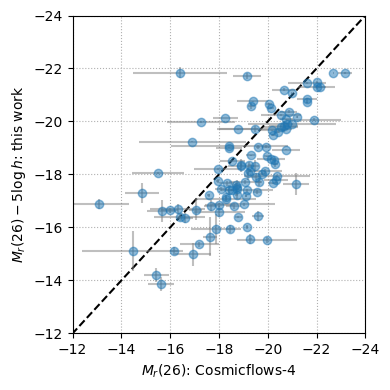

In [36]:
plt.figure(figsize=(4,4), tight_layout=True)

plt.grid(ls=':')

plt.plot([-5, -28], [-5, -28], 'k--')

plt.errorbar(SGA_0pt['R_ABSMAG_SB26_CF4'], SGA_0pt['R_ABSMAG_SB26_us'], 
             xerr=SGA_0pt['R_ABSMAG_SB26_CF4_err_stat'], 
             yerr=SGA_0pt['R_ABSMAG_SB26_us_err_stat'], 
             fmt='o', 
             alpha=0.5, 
             ecolor='gray'
            )

plt.xlim([-12, -24])
plt.ylim([-12, -24])

plt.xlabel('$M_r(26)$: Cosmicflows-4')
plt.ylabel('$M_r(26) - 5\log h$: this work');

In [37]:
# Restrict the sample to the range allowed by the Cosmicflows-4 calibration

StoN = SGA_0pt['V_HI']/SGA_0pt['VERR_HI']

CF4_boolean = (StoN > 10) & ((SGA_0pt['V_HI_corr'] - 6) > 64)

print(sum(CF4_boolean))

55


In [38]:
# Mark dwarf galaxies differently

dwarf_boolean = SGA_0pt['R_ABSMAG_SB26_us'] > -17

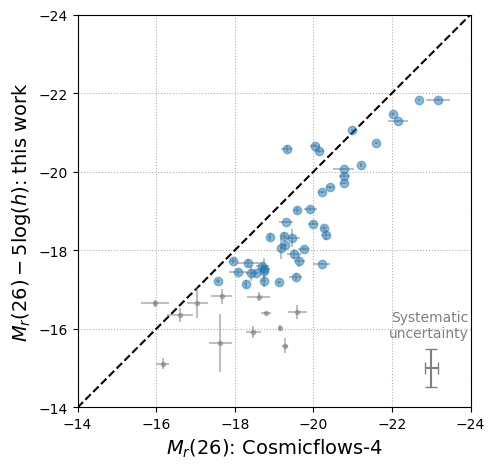

In [39]:
#plt.figure(figsize=(4,4), tight_layout=True)
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.plot([-5, -28], [-5, -28], 'k--')

# Statistical error bars
plt.errorbar(SGA_0pt['R_ABSMAG_SB26_CF4'][CF4_boolean & ~dwarf_boolean], SGA_0pt['R_ABSMAG_SB26_us'][CF4_boolean & ~dwarf_boolean], 
             xerr=SGA_0pt['R_ABSMAG_SB26_CF4_err_stat'][CF4_boolean & ~dwarf_boolean], 
             yerr=SGA_0pt['R_ABSMAG_SB26_us_err_stat'][CF4_boolean & ~dwarf_boolean], 
             fmt='o', 
             alpha=0.5, 
             ecolor='gray')
plt.errorbar(SGA_0pt['R_ABSMAG_SB26_CF4'][CF4_boolean & dwarf_boolean], SGA_0pt['R_ABSMAG_SB26_us'][CF4_boolean & dwarf_boolean], 
             xerr=SGA_0pt['R_ABSMAG_SB26_CF4_err_stat'][CF4_boolean & dwarf_boolean], 
             yerr=SGA_0pt['R_ABSMAG_SB26_us_err_stat'][CF4_boolean & dwarf_boolean], 
             fmt='.',
             color='gray',
             alpha=0.5, 
             ecolor='gray')

# Systematic error bar example
plt.errorbar([-23], [-15], 
             xerr=np.nanmean(SGA_0pt['R_ABSMAG_SB26_CF4_err_sys'][CF4_boolean]),
             yerr=np.nanmean(SGA_0pt['R_ABSMAG_SB26_us_err_sys'][CF4_boolean]), 
             # fmt='x', 
             # color='lightgray',
             ecolor='gray', 
             capsize=4)
plt.annotate('Systematic\nuncertainty', 
             (-23.95, -16.1), 
             #rotation='vertical', 
             va='center',
             ha='right',
             c='gray')

plt.gca().set_aspect('equal')

plt.xlim([-14, -24])
plt.ylim([-14, -24])

plt.xlabel('$M_r(26)$: Cosmicflows-4', fontsize=14)
plt.ylabel('$M_r(26) - 5$log$(h)$: this work', fontsize=14);

#plt.savefig('../../Figures/SV/fuji_CF4comp_20230817.png', dpi=150);

In [40]:
SGA_0pt[['SGA_ID', 'PGC', 'RA', 'DEC', 'MORPHTYPE', 'V_0p33R26']][dwarf_boolean & CF4_boolean]

SGA_ID,PGC,RA,DEC,MORPHTYPE,V_0p33R26
int64,int64,float64,float64,bytes21,float64
25532,4107586,195.97667146704435,28.31062379047577,S?,45.21383869804962
180872,3359401,210.5550679154331,4.095086710695675,S?,51.532660223040224
364410,1830228,193.281400534981,28.241241954832162,Sm,56.423829464993354
396176,49887,210.21868561504152,6.4864115495043,Scd,40.521168688696356
566771,1787484,194.66605475983752,26.759414937446905,Sc,59.34881339009334
740959,1709453,195.9035473489815,24.52641481011893,Scd,35.21895588563862
915738,51780,217.39419631188076,-0.01834178411395266,Sc,46.49003148387144
995155,3123667,218.38951908180513,3.2746705117849975,Sm,59.53062784973373
1079746,1251141,149.23384322173024,3.382802898040825,Sc,52.7694288398394


## Compute the absolute magnitudes based on our TFR

Here, the slope is from `Coma-Fuji-ITFR-nodwarfs_KAD.ipynb` and the 0-pt is from the EDD calibration (`fuji_zero-point_ITFR_nodwarf_KAD.ipynb`):

\begin{equation}
  M_r = a (\log(V(0.33R_{26})) - V_0) + b
\end{equation}

With $V_0 = 2.5$, when the uncertainties are taken into account, the best-fit values are
* $a = -7.89^{+1.16}_{-1.62} = -7.89\pm 1.57$
* $b = -22.34^{+0.18}_{-0.25} = -22.34 \pm 0.25$

*(Updated 1/30/24)*

In [41]:
'''
our_bright_slope = -7.81
our_bright_slope_err = 1.92

our_bright_ZP = -22.33
our_bright_ZP_err = 0.29
''';

temp_infile = open('cov_ab_fuji_zero-point_ITFR_nodwarf1_KAD.pickle', 'rb')
cov_ab_bright, itfr_samples_bright, tfr_samples_bright = pickle.load(temp_infile)
temp_infile.close()

our_bright_slope = np.median(tfr_samples_bright[0])
our_bright_ZP = np.median(tfr_samples_bright[1])

print(our_bright_slope, our_bright_ZP)

-7.888001821078532 -22.338298654078372


In [42]:
SGA_0pt['R_ABSMAG_SB26_us_bright'] = our_bright_slope*(np.log10(SGA_0pt['V_0p33R26']) - V0) + our_bright_ZP

In [43]:
#m_random = rng.normal(our_bright_slope, our_bright_slope_err, size=N_samples)
#b_random = rng.normal(our_bright_ZP, our_bright_ZP_err, size=N_samples)
#m_random, b_random = rng.multivariate_normal([our_bright_slope, our_bright_ZP], cov_ab_bright, N_samples).T
m_random = tfr_samples_bright[0]
b_random = tfr_samples_bright[1]

SGA_0pt['R_ABSMAG_SB26_us_bright_err'] = np.nan
SGA_0pt['R_ABSMAG_SB26_us_bright_err_stat'] = np.nan

for i in range(len(SGA_0pt)):
    
    v_random = rng.normal(SGA_0pt['V_0p33R26'][i], SGA_0pt['V_0p33R26_err'][i], size=len(m_random))
    #v_random = rng.normal(SGA_0pt['V_0p33R26'][i], 0.0, size=N_samples)
    
    ############################################################################
    # Statistical uncertainty
    #---------------------------------------------------------------------------
    Ms_stat = our_bright_slope*(np.log10(v_random) - V0) + our_bright_ZP
    
    SGA_0pt['R_ABSMAG_SB26_us_bright_err_stat'][i] = np.nanstd(Ms_stat)
    ############################################################################
    
    
    ############################################################################
    # Total uncertainty
    #---------------------------------------------------------------------------
    Ms = m_random*(np.log10(v_random) - V0) + b_random
    
    SGA_0pt['R_ABSMAG_SB26_us_bright_err'][i] = np.nanstd(Ms)
    ############################################################################

    
    
################################################################################
# Systematic uncertainty (due to the uncertainty in the fit)
#-------------------------------------------------------------------------------
SGA_0pt['R_ABSMAG_SB26_us_bright_err_sys'] = np.sqrt(SGA_0pt['R_ABSMAG_SB26_us_bright_err']**2 - SGA_0pt['R_ABSMAG_SB26_us_bright_err_stat']**2)
################################################################################

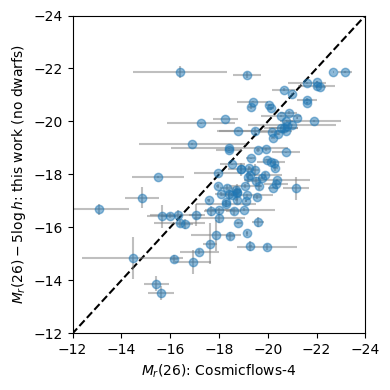

In [44]:
plt.figure(figsize=(4,4), tight_layout=True)

plt.plot([-5, -28], [-5, -28], 'k--')

plt.errorbar(SGA_0pt['R_ABSMAG_SB26_CF4'], SGA_0pt['R_ABSMAG_SB26_us_bright'], 
             xerr=SGA_0pt['R_ABSMAG_SB26_CF4_err_stat'], 
             yerr=SGA_0pt['R_ABSMAG_SB26_us_bright_err_stat'], 
             fmt='o', 
             alpha=0.5, 
             ecolor='gray')

plt.xlim([-12, -24])
plt.ylim([-12, -24])

plt.xlabel('$M_r(26)$: Cosmicflows-4')
plt.ylabel('$M_r(26) - 5\log h$: this work (no dwarfs)');

In [45]:
# Mark dwarf galaxies differently

bright_dwarf_boolean = SGA_0pt['R_ABSMAG_SB26_us_bright'] > -17

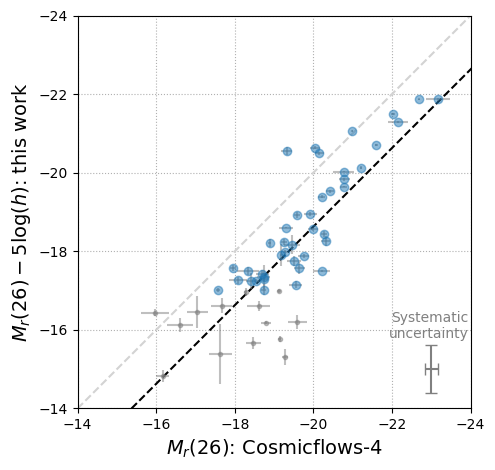

In [50]:
H0 = 76.0 # From Kourkchi et al. (2020a)
h = H0/100

#plt.figure(figsize=(4,4), tight_layout=True)
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.plot([-5, -28], [-5, -28], '--', color='lightgray')
plt.plot([-5, -28], np.array([-5, -28]) - 5*np.log(h), 'k--') # with H0 from Cosmicflows 4

plt.errorbar(SGA_0pt['R_ABSMAG_SB26_CF4'][CF4_boolean & ~bright_dwarf_boolean], SGA_0pt['R_ABSMAG_SB26_us_bright'][CF4_boolean & ~bright_dwarf_boolean], 
             xerr=SGA_0pt['R_ABSMAG_SB26_CF4_err_stat'][CF4_boolean & ~bright_dwarf_boolean], 
             yerr=SGA_0pt['R_ABSMAG_SB26_us_bright_err_stat'][CF4_boolean & ~bright_dwarf_boolean], 
             fmt='o', 
             alpha=0.5, 
             ecolor='gray')
plt.errorbar(SGA_0pt['R_ABSMAG_SB26_CF4'][CF4_boolean & bright_dwarf_boolean], SGA_0pt['R_ABSMAG_SB26_us_bright'][CF4_boolean & bright_dwarf_boolean], 
             xerr=SGA_0pt['R_ABSMAG_SB26_CF4_err_stat'][CF4_boolean & bright_dwarf_boolean], 
             yerr=SGA_0pt['R_ABSMAG_SB26_us_bright_err_stat'][CF4_boolean & bright_dwarf_boolean], 
             fmt='.',
             color='gray',
             alpha=0.5, 
             ecolor='gray')

# Systematic error bar example
plt.errorbar([-23], [-15], 
             xerr=np.nanmean(SGA_0pt['R_ABSMAG_SB26_CF4_err_sys'][CF4_boolean]),
             yerr=np.nanmean(SGA_0pt['R_ABSMAG_SB26_us_bright_err_sys'][CF4_boolean]), 
             # fmt='x', 
             # color='lightgray',
             ecolor='gray', 
             capsize=4)
plt.annotate('Systematic\nuncertainty', 
             (-23.95, -16.1), 
             #rotation='vertical', 
             va='center',
             ha='right',
             c='gray')

plt.gca().set_aspect('equal')

plt.xlim([-14, -24])
plt.ylim([-14, -24])

plt.xlabel('$M_r(26)$: Cosmicflows-4', fontsize=14)
#plt.ylabel('$M_r(26) - 5\log(h)$: this work (no dwarfs)', fontsize=14);
plt.ylabel('$M_r(26) - 5\log(h)$: this work', fontsize=14);

plt.savefig('../../Figures/SV/fuji_CF4comp_nodwarf1_20240521.png', 
            dpi=150, 
            facecolor='none');

# Estimate of $H_0$

Because our 0-pt is not calibrated with the distance ladder, our estimates of the luminosity are independent of $H_0$.  Cosmicflows-4 *did* use the distance ladder for their calibration, so they have the Hubble constant baked into their luminosities.  We can therefore estimate $H_0$ by computing the difference between these two absolute magnitudes.

In [44]:
SGA_0pt['h'] = 10**(0.2*(SGA_0pt['R_ABSMAG_SB26_CF4'] - SGA_0pt['R_ABSMAG_SB26_us_bright']))

In [45]:
SGA_0pt['h_err'] = np.nan

for i in range(len(SGA_0pt)):
    
    us_random = rng.normal(SGA_0pt['R_ABSMAG_SB26_us_bright'][i], 
                           SGA_0pt['R_ABSMAG_SB26_us_bright_err'][i], 
                           size=N_samples)
    CF4_random = rng.normal(SGA_0pt['R_ABSMAG_SB26_CF4'][i], 
                            SGA_0pt['R_ABSMAG_SB26_CF4_err'][i], 
                            size=N_samples)
    
    hs = 10**(0.2*(CF4_random - us_random))
    
    SGA_0pt['h_err'][i] = np.nanstd(hs)

In [46]:
weights = 1./(SGA_0pt['h_err']**2)

h_measured = np.average(SGA_0pt['h'][CF4_boolean & ~bright_dwarf_boolean], 
                        weights=weights[CF4_boolean & ~bright_dwarf_boolean])

h_measured_err = np.sqrt(1./np.sum(weights[CF4_boolean & ~bright_dwarf_boolean]))

print(f'{h_measured:.2f} +/- {h_measured_err:.3f}')

0.66 +/- 0.019


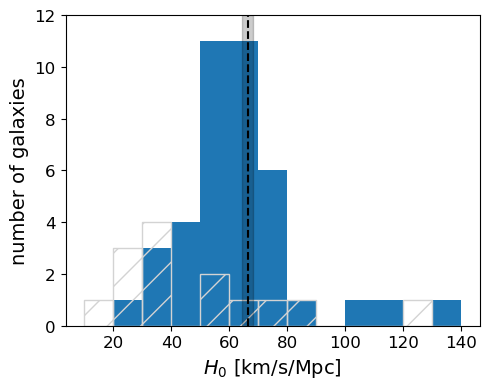

In [47]:
plt.figure(figsize=(5,4), tight_layout=True)

bins = np.arange(10, 150, 10)

plt.hist(100*SGA_0pt['h'][CF4_boolean & ~bright_dwarf_boolean], bins=bins)
plt.hist(100*SGA_0pt['h'][CF4_boolean & bright_dwarf_boolean], bins=bins, facecolor='none', edgecolor='lightgray', hatch='/')

plt.vlines(100*h_measured, 0, 15, 'k', linestyle='dashed')
plt.fill_betweenx([0,12], 100*(h_measured - h_measured_err), 100*(h_measured + h_measured_err), color='k', alpha=0.2)

plt.ylim((0, 12))

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel('$H_0$ [km/s/Mpc]', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14);

plt.savefig('../../Figures/SV/fuji_H0_hist_20240130.png', 
            dpi=150, 
            facecolor='none');

## Do I get a different estimate by fitting a line to the scatter plot?

I'm going to fix the slope to 1, so we're just letting the $y$-intercept float.

In [48]:
def zero_point(b, m, x):
    '''
    Equation of a line
    
    
    PARAMETERS
    ==========
    
    b : float
        y-intercept of line (this is what is being fit for)
    
    m : float
        Slope of line
    
    x : np.ndarray of shape (n,)
        x-values of line
    
    
    RETURNS
    =======
    
    y : np.ndarray of shape (n,)
        y-values calculated with the provided inputs
    '''
    
    y = m*x + b
    
    return y



def calculate_chi2(b, m, x, x_err, y, y_err):
    '''
    Calculate the reduced chi2 value of the current line.
    
    
    PARAMETERS
    ==========
    
    b : float
        y-intercept of the line (this is what is being fit for)
        
    m : floats
        Slope of the line
    
    x, x_err : np.ndarrays of shape (n,)
        x-values and uncertainties in the x-values
    
    y, y_err : np.ndarrays of shape (n,)
        y-values and uncertainties in the y-values
    
    
    RETURNS
    =======
    
    chi2 : float
        Chi2 value of the current best fit (given by b)
    '''
    
    ############################################################################
    # Calculate the values of the current best-fit line
    #---------------------------------------------------------------------------
    y_fit = zero_point(b, m, x)
    ############################################################################
    
    
    ############################################################################
    # Calculate chi2 of current fit
    #---------------------------------------------------------------------------
    chi2 = np.sum((y - y_fit)**2/(y_err**2 + (m*x_err)**2))
    
    #chi2_norm = chi2/(len(x) - 1) # Only one free parameter in this fit
    ############################################################################
    
    return chi2#_norm

In [50]:
b_guess = 0

result = minimize(calculate_chi2, 
                  b_guess, 
                  args=(1, 
                        SGA_0pt['R_ABSMAG_SB26_CF4'][CF4_boolean & ~bright_dwarf_boolean], 
                        SGA_0pt['R_ABSMAG_SB26_CF4_err_stat'][CF4_boolean & ~bright_dwarf_boolean], 
                        SGA_0pt['R_ABSMAG_SB26_us_bright'][CF4_boolean & ~bright_dwarf_boolean], 
                        SGA_0pt['R_ABSMAG_SB26_us_bright_err_stat'][CF4_boolean & ~bright_dwarf_boolean]), 
                  bounds=[[-10, 10]])

b_fit = result.x[0]

In [51]:
h = 10**(-0.2*b_fit)

print(f'{h_measured:.2f}')# +/- {h_measured_err:.3f}')

0.66


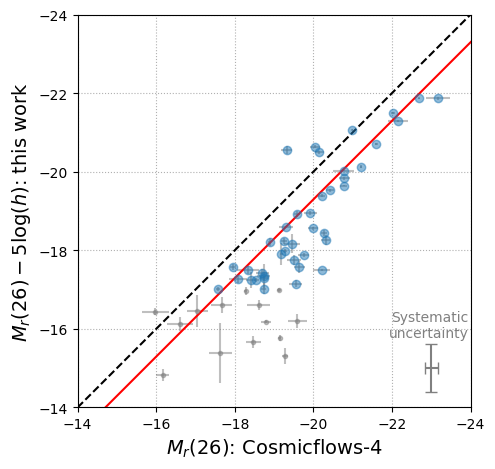

In [53]:
#plt.figure(figsize=(4,4), tight_layout=True)
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.plot([-5, -28], [-5, -28], 'k--')

plt.errorbar(SGA_0pt['R_ABSMAG_SB26_CF4'][CF4_boolean & ~bright_dwarf_boolean], SGA_0pt['R_ABSMAG_SB26_us_bright'][CF4_boolean & ~bright_dwarf_boolean], 
             xerr=SGA_0pt['R_ABSMAG_SB26_CF4_err_stat'][CF4_boolean & ~bright_dwarf_boolean], 
             yerr=SGA_0pt['R_ABSMAG_SB26_us_bright_err_stat'][CF4_boolean & ~bright_dwarf_boolean], 
             fmt='o', 
             alpha=0.5, 
             ecolor='gray')
plt.errorbar(SGA_0pt['R_ABSMAG_SB26_CF4'][CF4_boolean & bright_dwarf_boolean], SGA_0pt['R_ABSMAG_SB26_us_bright'][CF4_boolean & bright_dwarf_boolean], 
             xerr=SGA_0pt['R_ABSMAG_SB26_CF4_err_stat'][CF4_boolean & bright_dwarf_boolean], 
             yerr=SGA_0pt['R_ABSMAG_SB26_us_bright_err_stat'][CF4_boolean & bright_dwarf_boolean], 
             fmt='.',
             color='gray',
             alpha=0.5, 
             ecolor='gray')

# Plot fit
plt.plot([-5, -28], [-5, -28] + b_fit, 'r')

# Systematic error bar example
plt.errorbar([-23], [-15], 
             xerr=np.nanmean(SGA_0pt['R_ABSMAG_SB26_CF4_err_sys'][CF4_boolean]),
             yerr=np.nanmean(SGA_0pt['R_ABSMAG_SB26_us_bright_err_sys'][CF4_boolean]), 
             # fmt='x', 
             # color='lightgray',
             ecolor='gray', 
             capsize=4)
plt.annotate('Systematic\nuncertainty', 
             (-23.95, -16.1), 
             #rotation='vertical', 
             va='center',
             ha='right',
             c='gray')

plt.gca().set_aspect('equal')

plt.xlim([-14, -24])
plt.ylim([-14, -24])

plt.xlabel('$M_r(26)$: Cosmicflows-4', fontsize=14)
#plt.ylabel('$M_r(26) - 5\log(h)$: this work (no dwarfs)', fontsize=14);
plt.ylabel('$M_r(26) - 5\log(h)$: this work', fontsize=14);

# plt.savefig('../../Figures/SV/fuji_CF4comp_nodwarf1_20240130.png', 
#             dpi=150, 
#             facecolor='none');